# Exploratory Analysis
To begin this exploratory analysis, first import libraries and prepare the data. 

In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import time
from sklearn import metrics
from sklearn import neighbors
from sklearn import ensemble
from sklearn import tree
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from pandas.plotting import scatter_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from datetime import datetime, date, time, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
import matplotlib.ticker as mtick
import scikitplot as skplt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import svm
plt.style.use('ggplot')

# Data Preparation

## Import and Update tables

In [92]:
# import and update table card
card = pd.read_csv(
    "../input/card.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
card.issued = card.issued.str.strip("00:00:00")
card.type = card.type.map({"gold": 2, "classic": 1, "junior": 0})
card.head()


,card_id,disp_id,type,issued
0,1005,9285,1,931107
1,104,588,1,940119
2,747,4915,1,940205
3,70,439,1,940208
4,577,3687,1,940215


In [93]:
# import and update table account
account = pd.read_csv(
    "../input/account.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
)
account.date = account.date.apply(lambda x: pd.to_datetime(str(x), format="%y%m%d"))
account.head()


,account_id,district_id,frequency,date
0,576,55,POPLATEK MESICNE,1993-01-01
1,3818,74,POPLATEK MESICNE,1993-01-01
2,704,55,POPLATEK MESICNE,1993-01-01
3,2378,16,POPLATEK MESICNE,1993-01-01
4,2632,24,POPLATEK MESICNE,1993-01-02


In [94]:
# import and update table disp
disp = pd.read_csv(
    "../input/disp.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
disp = disp[disp.type == "OWNER"]
disp.rename(columns={"type": "type_disp"}, inplace=True)
disp.head()


,disp_id,client_id,account_id,type_disp
0,1,1,1,OWNER
1,2,2,2,OWNER
3,4,4,3,OWNER
5,6,6,4,OWNER
6,7,7,5,OWNER


In [95]:
# import and update table client
client = pd.read_csv(
    "../input/client.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
client["month"] = client.birth_number.apply(
    lambda x: x // 100 % 100, convert_dtype=True, args=()
)
client["year"] = client.birth_number.apply(
    lambda x: x // 100 // 100, convert_dtype=True, args=()
)
client["age"] = 99 - client.year
client["sex"] = client.month.apply(lambda x: (x - 50) < 0, convert_dtype=True, args=())
client.sex = client.sex.astype(int)  # 0 for female, 1 for male
client.drop(["birth_number", "month", "year"], axis=1, inplace=True)
client.head()


,client_id,district_id,age,sex
0,1,18,29,0
1,2,1,54,1
2,3,1,59,0
3,4,5,43,1
4,5,5,39,0


In [96]:
# import and update table district
district = pd.read_csv(
    "../input/district.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
district.drop(["A2", "A3"], axis=1, inplace=True)
district.head()


,A1,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [97]:
# import and update table order
order = pd.read_csv(
    "../input/order.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
order.drop(["bank_to", "account_to", "order_id"], axis=1, inplace=True)
order.k_symbol.fillna("No_symbol")
order.k_symbol = order.k_symbol.str.replace(" ", "No_symbol")
order = order.groupby(["account_id", "k_symbol"]).mean().unstack()
order = order.fillna(0)
order.columns = order.columns.droplevel()
order.reset_index(level="account_id", col_level=1, inplace=True)
order.rename_axis("", axis="columns", inplace=True)
order.rename(
    index=None,
    columns={
        "LEASING": "order_amount_LEASING",
        "No_symbol": "order_amount_No_symbol",
        "POJISTNE": "order_amount_POJISTNE",
        "SIPO": "order_amount_SIPO",
        "UVER": "order_amount_UVER",
    },
    inplace=True,
)
order.head()


,account_id,order_amount_LEASING,order_amount_No_symbol,order_amount_POJISTNE,order_amount_SIPO,order_amount_UVER
0,1,0.0,0.0,0.0,2452.0,0.0
1,2,0.0,0.0,0.0,7266.0,3372.7
2,3,0.0,327.0,3539.0,1135.0,0.0
3,4,0.0,0.0,0.0,1681.5,0.0
4,5,0.0,0.0,0.0,2668.0,0.0


In [98]:
# import and update table loan
loan = pd.read_csv(
    "../input/loan.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
loan.date = loan.date.apply(lambda x: pd.to_datetime(str(x), format="%y%m%d"))
loan.head()


,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,1993-07-05,96396,12,8033.0,B
1,5316,1801,1993-07-11,165960,36,4610.0,A
2,6863,9188,1993-07-28,127080,60,2118.0,A
3,5325,1843,1993-08-03,105804,36,2939.0,A
4,7240,11013,1993-09-06,274740,60,4579.0,A


In [99]:
# import and update table trans
trans = pd.read_csv(
    "../input/trans.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
trans.loc[trans.k_symbol == "", "k_symbol"] = trans[
    trans.k_symbol == ""
].k_symbol.apply(lambda x: "k_symbol_missing")
trans.loc[trans.k_symbol == " ", "k_symbol"] = trans[
    trans.k_symbol == " "
].k_symbol.apply(lambda x: "k_symbol_missing")
loan_account_id = loan.loc[:, ["account_id"]]
trans = loan_account_id.merge(trans, how="left", on="account_id")
trans.date = trans.date.apply(lambda x: pd.to_datetime(str(x), format="%y%m%d"))
trans.head()


,account_id,trans_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1787,523621,1993-03-22,PRIJEM,VKLAD,1100.0,1100.0,NaN,NaN,NaN
1,1787,524054,1993-04-21,PRIJEM,VKLAD,9900.0,11000.0,NaN,NaN,NaN
2,1787,524055,1993-05-21,PRIJEM,VKLAD,5800.0,16800.0,NaN,NaN,NaN
3,1787,524056,1993-06-20,PRIJEM,VKLAD,3300.0,20100.0,NaN,NaN,NaN
4,1787,523624,1993-07-08,PRIJEM,VKLAD,42248.0,62348.0,NaN,NaN,NaN


In [100]:
# create temp table trans_pv_k_symbol
trans_pv_k_symbol = trans.pivot_table(
    values=["amount", "balance"], index=["trans_id"], columns="k_symbol"
)
trans_pv_k_symbol.fillna(0, inplace=True)
trans_pv_k_symbol.columns = ["_".join(col) for col in trans_pv_k_symbol.columns]
trans_pv_k_symbol = trans_pv_k_symbol.reset_index()
trans_pv_k_symbol = trans.iloc[:, :3].merge(
    trans_pv_k_symbol, how="left", on="trans_id"
)
trans_pv_k_symbol.head()


,account_id,trans_id,date,amount_POJISTNE,amount_SANKC. UROK,amount_SIPO,amount_SLUZBY,amount_UROK,amount_UVER,amount_k_symbol_missing,balance_POJISTNE,balance_SANKC. UROK,balance_SIPO,balance_SLUZBY,balance_UROK,balance_UVER,balance_k_symbol_missing
0,1787,523621,1993-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1787,524054,1993-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1787,524055,1993-05-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1787,524056,1993-06-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1787,523624,1993-07-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
# create temp table get_date_loan_trans
get_date_loan_trans = pd.merge(
    loan,
    account,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_loan", "_account"),
    copy=True,
    indicator=False,
    validate=None,
)
get_date_loan_trans = pd.merge(
    get_date_loan_trans,
    trans,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_account", "_trans"),
    copy=True,
    indicator=False,
    validate=None,
)


In [102]:
# update table get_date_loan_trans to get the date between loan_date and trans_date.
get_date_loan_trans["date_loan_trans"] = (
    get_date_loan_trans.date_loan - get_date_loan_trans.date
)
get_date_loan_trans[["date_loan_trans"]] = get_date_loan_trans[
    ["date_loan_trans"]
].astype(str)
get_date_loan_trans.date_loan_trans = get_date_loan_trans.date_loan_trans.str.strip(
    " days 00:00:00.000000000"
)
get_date_loan_trans.date_loan_trans = pd.to_numeric(
    get_date_loan_trans.date_loan_trans.str.strip(" days +")
)
get_date_loan_trans.head()


,loan_id,account_id,date_loan,amount_account,duration,payments,status,district_id,frequency,date_account,trans_id,date,type,operation,amount_trans,balance,k_symbol,bank,account,date_loan_trans
0,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,523621,1993-03-22,PRIJEM,VKLAD,1100.0,1100.0,NaN,NaN,NaN,105.0
1,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,524054,1993-04-21,PRIJEM,VKLAD,9900.0,11000.0,NaN,NaN,NaN,75.0
2,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,524055,1993-05-21,PRIJEM,VKLAD,5800.0,16800.0,NaN,NaN,NaN,45.0
3,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,524056,1993-06-20,PRIJEM,VKLAD,3300.0,20100.0,NaN,NaN,NaN,15.0
4,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,523624,1993-07-08,PRIJEM,VKLAD,42248.0,62348.0,NaN,NaN,NaN,-3.0


In [103]:
# create temp table temp_90_mean to create new feature
temp_90_mean = get_date_loan_trans[
    (get_date_loan_trans["date_loan_trans"] >= 0)
    & (get_date_loan_trans["date_loan_trans"] < 90)
]
temp_90_mean = temp_90_mean.drop(["trans_id", "k_symbol"], axis=1)
temp_90_mean = temp_90_mean.groupby(["loan_id"], as_index=None).mean()
temp_90_mean = temp_90_mean.loc[:, ["loan_id", "balance"]]
temp_90_mean.rename(
    index=None, columns={"balance": "avg_balance_3M_befroe_loan"}, inplace=True
)


In [104]:
# create temp table temp_30_mean to create new feature
temp_30_mean = get_date_loan_trans[
    (get_date_loan_trans["date_loan_trans"] >= 0)
    & (get_date_loan_trans["date_loan_trans"] < 30)
]
temp_30_mean = temp_30_mean.drop(["trans_id", "k_symbol"], axis=1)
temp_30_mean = temp_30_mean.groupby(["loan_id"], as_index=None).mean()
temp_30_mean = temp_30_mean.loc[:, ["loan_id", "balance"]]
temp_30_mean.rename(
    index=None, columns={"balance": "avg_balance_1M_befroe_loan"}, inplace=True
)


In [105]:
# create temp table temp_trans_freq to create new feature
temp_before = get_date_loan_trans[(get_date_loan_trans["date_loan_trans"] >= 0)]
temp_trans_freq = (
    temp_before.loc[:, ["loan_id", "trans_id"]]
    .groupby(["loan_id"], as_index=None)
    .count()
)
temp_trans_freq.rename(index=None, columns={"trans_id": "trans_freq"}, inplace=True)
temp_before = temp_before.drop(["trans_id", "k_symbol"], axis=1)


In [106]:
# create temp table temp_balance_min & temp_balance_mean to create new features
temp_balance_min = (
    temp_before.groupby(["loan_id"], as_index=None).min().loc[:, ["loan_id", "balance"]]
)
temp_balance_min.rename(
    index=None, columns={"balance": "min_balance_befroe_loan"}, inplace=True
)

temp_balance_mean = (
    temp_before.groupby(["loan_id"], as_index=None)
    .mean()
    .loc[:, ["loan_id", "amount_trans", "balance"]]
)
temp_balance_mean.rename(
    index=None,
    columns={
        "amount_trans": "avg_amount_trans_before_loan",
        "balance": "avg_balance_before_loan",
    },
    inplace=True,
)


In [107]:
# create temp table times_balance_below_500 & times_balance_below_5K to create new features
times_balance_below_500 = temp_before[temp_before.balance < 500]
times_balance_below_500 = (
    times_balance_below_500.groupby(["loan_id"], as_index=None)
    .count()
    .loc[:, ["loan_id", "balance"]]
)
times_balance_below_500 = times_balance_below_500[times_balance_below_500.balance > 1]
times_balance_below_500.rename(
    index=str, columns={"balance": "times_balance_below_500"}, inplace=True
)

times_balance_below_5K = temp_before[temp_before.balance < 5000]
times_balance_below_5K = (
    times_balance_below_5K.groupby(["loan_id"], as_index=None)
    .count()
    .loc[:, ["loan_id", "balance"]]
)
times_balance_below_5K = times_balance_below_5K[times_balance_below_5K.balance > 1]
times_balance_below_5K.rename(
    index=str, columns={"balance": "times_balance_below_5K"}, inplace=True
)


In [108]:
# create temp table merge_loan_trans to merge the temp features above into one temp table
merge_loan_trans = loan.merge(
    temp_90_mean, how="left", on="loan_id", suffixes=("_loan", "_trans")
)
merge_loan_trans = merge_loan_trans.merge(temp_30_mean, how="left", on="loan_id")
merge_loan_trans = merge_loan_trans.merge(temp_trans_freq, how="left", on="loan_id")
merge_loan_trans = merge_loan_trans.merge(temp_balance_min, how="left", on="loan_id")
merge_loan_trans = merge_loan_trans.merge(temp_balance_mean, how="left", on="loan_id")
merge_loan_trans = merge_loan_trans.merge(
    times_balance_below_500, how="left", on="loan_id"
)
merge_loan_trans = merge_loan_trans.merge(
    times_balance_below_5K, how="left", on="loan_id"
)


In [109]:
loan_BorD = loan[(loan.status == "D") | (loan.status == "B")]
len(loan_BorD)


76

In [110]:
temp = times_balance_below_500.merge(
    loan,
    how="inner",
    on="loan_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

temp.status.value_counts()


D    17
B     7
A     2
Name: status, dtype: int64

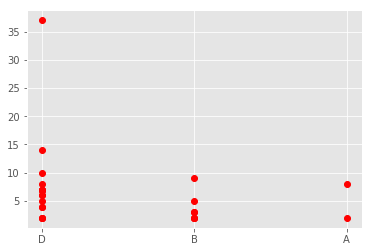

In [111]:
plt.plot(temp.status, temp.times_balance_below_500, "ro")


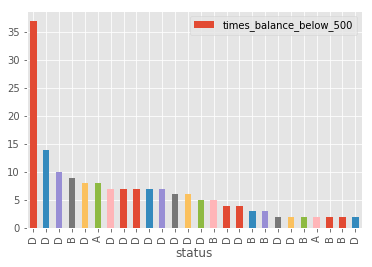

In [112]:
temp.sort_values("times_balance_below_500", ascending=False).plot(
    x="status", y="times_balance_below_500", kind="bar"
)


In [113]:
t = loan.loc[:, ["payments", "status"]]
t.head(3)


,payments,status
0,8033.0,B
1,4610.0,A
2,2118.0,A


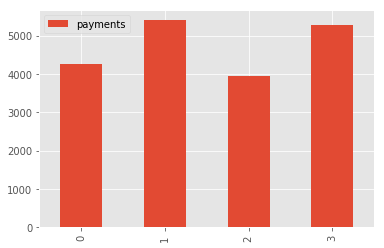

In [114]:
t = t.groupby(["status"], as_index=None).mean()
t.plot(kind="bar")


# Merge tables

In [115]:
df = pd.merge(
    merge_loan_trans,
    account,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_loan", "_account"),
    copy=True,
    indicator=False,
    validate=None,
)


In [116]:
df = pd.merge(
    df,
    order,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_a", "_order"),
    copy=True,
    indicator=False,
    validate=None,
)


In [117]:
df = pd.merge(
    df,
    disp,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_b", "_disp"),
    copy=True,
    indicator=False,
    validate=None,
)


In [118]:
df = pd.merge(
    df,
    card,
    how="left",
    on="disp_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_c", "_card"),
    copy=True,
    indicator=False,
    validate=None,
)


In [119]:
df = pd.merge(
    df,
    client,
    how="left",
    on="client_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_d", "_client"),
    copy=True,
    indicator=False,
    validate=None,
)


In [120]:
df = pd.merge(
    df,
    district,
    how="left",
    left_on="district_id_client",
    right_on="A1",
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_e", "_district"),
    copy=True,
    indicator=False,
    validate=None,
)


In [121]:
before_loan_date = get_date_loan_trans[(get_date_loan_trans["date_loan_trans"] >= 0)]
before_loan_date = before_loan_date.loc[:, ["account_id", "trans_id"]]
trans_pv_k_symbol = pd.merge(
    before_loan_date,
    trans_pv_k_symbol,
    how="left",
    on="trans_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_before", "_df2"),
    copy=True,
    indicator=False,
    validate=None,
)
trans_pv_k_symbol.drop(
    ["account_id_df2", "date", "trans_id"], axis=1, inplace=True
)
trans_pv_k_symbol.rename(columns={"account_id_before": "account_id"}, inplace=True)
trans_pv_k_symbol = trans_pv_k_symbol.groupby(
    by="account_id", axis=0, as_index=False, sort=True, group_keys=True, squeeze=False
).mean()


In [122]:
df = pd.merge(
    df,
    trans_pv_k_symbol,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_df", "_tt"),
    copy=True,
    indicator=False,
    validate=None,
)


# Data Cleaning

In [123]:
df["year_"] = df.date_loan.apply(lambda x: x.year, convert_dtype=int, args=())
df["years_of_loan"] = 1999 - df.year_
df.drop(["date_loan", "year_"], axis=1, inplace=True)
df.frequency = df.frequency.map(
    {"POPLATEK MESICNE": 30, "POPLATEK TYDNE": 7, "POPLATEK PO OBRATU": 1}
)


In [124]:
df["year_"] = df.date_account.apply(lambda x: x.year, convert_dtype=int, args=())
df["years_of_account"] = 1999 - df.year_
df.drop(["date_account", "year_", "type_disp"], axis=1, inplace=True)


In [125]:
df.issued.fillna("999999", inplace=True)
df["years_card_issued"] = df.issued.apply(
    lambda x: (99 - int(x[:2])), convert_dtype=int
)
df.drop(["issued","A12","A15"], axis=1, inplace=True)


In [126]:
df.fillna(0, inplace=True)


In [127]:
df.status.value_counts()


C    403
A    203
D     45
B     31
Name: status, dtype: int64

In [128]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 0 to 681
Data columns (total 57 columns):
loan_id                         682 non-null int64
account_id                      682 non-null int64
amount                          682 non-null int64
duration                        682 non-null int64
payments                        682 non-null float64
status                          682 non-null object
avg_balance_3M_befroe_loan      682 non-null float64
avg_balance_1M_befroe_loan      682 non-null float64
trans_freq                      682 non-null int64
min_balance_befroe_loan         682 non-null float64
avg_amount_trans_before_loan    682 non-null float64
avg_balance_before_loan         682 non-null float64
times_balance_below_500         682 non-null float64
times_balance_below_5K          682 non-null float64
district_id_d                   682 non-null int64
frequency                       682 non-null int64
order_amount_LEASING            682 non-null float64
order_amo

# Get label

In [129]:
m = {"A": 0, "B": 1, "C": 0, "D": 1}
df.status = df.status.map(m)
df.status.unique()


array([1, 0])

In [130]:
df = pd.get_dummies(df, drop_first=True)


In [131]:
df.columns.unique()

Index(['loan_id', 'account_id', 'amount', 'duration', 'payments', 'status',
       'avg_balance_3M_befroe_loan', 'avg_balance_1M_befroe_loan',
       'trans_freq', 'min_balance_befroe_loan', 'avg_amount_trans_before_loan',
       'avg_balance_before_loan', 'times_balance_below_500',
       'times_balance_below_5K', 'district_id_d', 'frequency',
       'order_amount_LEASING', 'order_amount_No_symbol',
       'order_amount_POJISTNE', 'order_amount_SIPO', 'order_amount_UVER',
       'disp_id', 'client_id', 'card_id', 'type', 'district_id_client', 'age',
       'sex', 'A1', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A13',
       'A14', 'A16', 'amount_POJISTNE', 'amount_SANKC. UROK', 'amount_SIPO',
       'amount_SLUZBY', 'amount_UROK', 'amount_UVER',
       'amount_k_symbol_missing', 'balance_POJISTNE', 'balance_SANKC. UROK',
       'balance_SIPO', 'balance_SLUZBY', 'balance_UROK', 'balance_UVER',
       'balance_k_symbol_missing', 'years_of_loan', 'years_of_account',
       'years

In [132]:
df.drop(
    [
        "loan_id",
        "account_id",
        "district_id_d",
        "disp_id",
        "client_id",
        "card_id",
        "district_id_client",
    ],
    axis=1,
    inplace=True,
)


# Standard processing and Training/Test set Split

In [133]:
X = df.loc[:, df.columns != "status"]
y = df.loc[:, "status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


# Model Evaluation

# Draft Modeling: Random Forest

In [134]:
rf = ensemble.RandomForestClassifier(
    n_estimators=200,
    criterion="gini",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features="auto",
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=1,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


In [135]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      1.00      0.95       179
           1       1.00      0.35      0.51        26

   micro avg       0.92      0.92      0.92       205
   macro avg       0.96      0.67      0.73       205
weighted avg       0.92      0.92      0.90       205



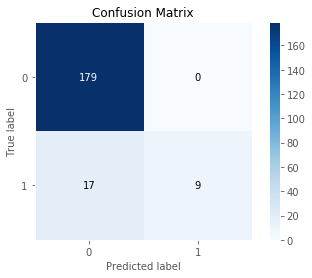

In [136]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)


In [137]:
fi = rf.feature_importances_


In [138]:
feature_cols = X_test.columns
importance = pd.DataFrame(
    {"feature": feature_cols, "importance": rf.feature_importances_}
)


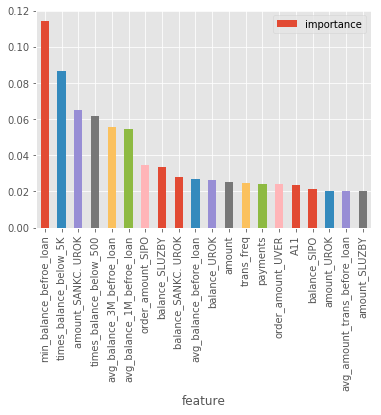

In [139]:
importance = pd.DataFrame(
    {"feature": feature_cols[:], "importance": rf.feature_importances_[:]}
)
importance.sort_values(
    by="importance",
    axis=0,
    ascending=False,
    inplace=True,
    kind="quicksort",
    na_position="last",
)
importance[:20].plot(x="feature", y="importance", kind="bar")


# Visualization & Feature Selection

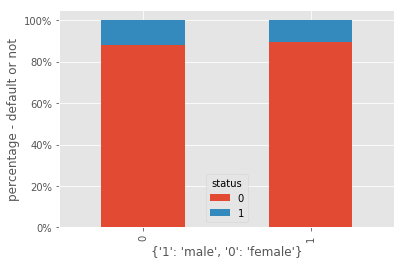

In [140]:
df.groupby(["sex", "status"])["status"].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind="bar", stacked=True)
plt.xlabel({"1": "male", "0": "female"})
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel("percentage - default or not")
plt.show()


In [141]:
df.groupby(["sex", "status"])["status"].size()


sex  status
0    0         307
     1          41
1    0         299
     1          35
Name: status, dtype: int64

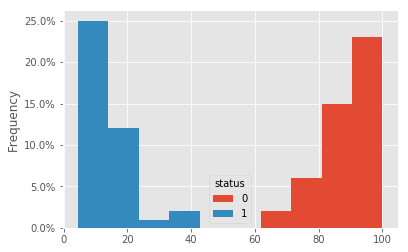

In [142]:
df.groupby(["age", "status"])["status"].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind="hist", stacked=True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()


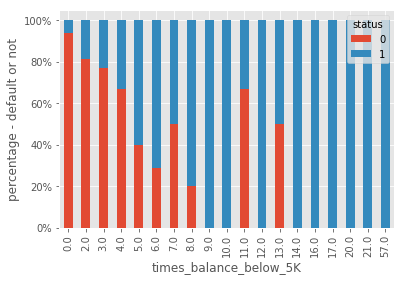

In [143]:
df.groupby(["times_balance_below_5K", "status"])["status"].size().groupby(
    level=0
).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind="bar", stacked=True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel("percentage - default or not")
plt.show()


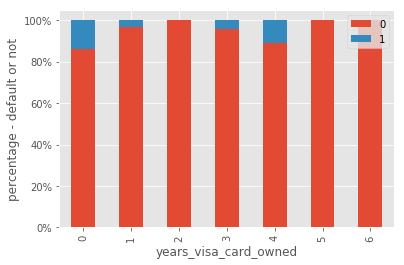

In [144]:
df.groupby(["years_card_issued", "status"])["status"].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind="bar", stacked=True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel("percentage - default or not")
plt.xlabel("years_visa_card_owned")
plt.legend(loc=1)
plt.show()


Text(0,0.5,'count_of_loan_id')

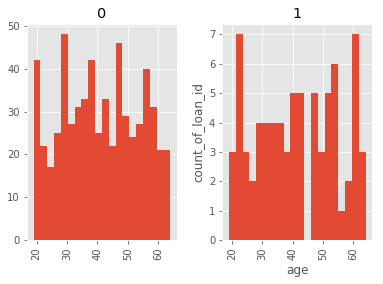

In [145]:
df.hist(column="age", by="status", bins=20)
plt.xlabel("age")
plt.ylabel("count_of_loan_id")


In [146]:
# Binning:
def binning(col, cut_points, labels=None):
    # Define min and max values:
    minval = col.min()
    maxval = col.max()

    # create list by adding min and max to cut_points
    break_points = [minval] + cut_points + [maxval]

    # if no labels provided, use default labels 0 ... (n-1)
    if not labels:
        labels = range(len(cut_points) + 1)

    # Binning using cut function of pandas
    colBin = pd.cut(col, bins=break_points, labels=labels, include_lowest=True)
    return colBin


# Binning age:
cut_points = [24, 34, 44, 50]
labels = ["20", "25", "35", "45", "50"]
df["age_bin"] = binning(df["age"], cut_points, labels)


Text(0,0.5,'percentage - default or not')

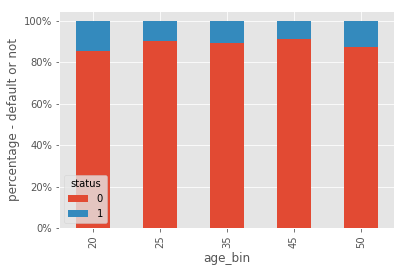

In [147]:
df.groupby(["age_bin", "status"])["status"].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind="bar", stacked=True)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

plt.ylabel("percentage - default or not")


In [148]:
df[df.status == 1].head()


,amount,duration,payments,status,avg_balance_3M_befroe_loan,avg_balance_1M_befroe_loan,trans_freq,min_balance_befroe_loan,avg_amount_trans_before_loan,avg_balance_before_loan,times_balance_below_500,times_balance_below_5K,frequency,order_amount_LEASING,order_amount_No_symbol,order_amount_POJISTNE,order_amount_SIPO,order_amount_UVER,type,age,sex,A1,A4,A5,A6,A7,A8,A9,A10,A11,A13,A14,A16,amount_POJISTNE,amount_SANKC. UROK,amount_SIPO,amount_SLUZBY,amount_UROK,amount_UVER,amount_k_symbol_missing,balance_POJISTNE,balance_SANKC. UROK,balance_SIPO,balance_SLUZBY,balance_UROK,balance_UVER,balance_k_symbol_missing,years_of_loan,years_of_account,years_card_issued,age_bin
0,96396,12,8033.0,1,15966.666667,20100.000000,4,1100.0,5025.000000,12250.000000,0.0,0.0,7,0.0,0.0,0.0,0.0,8033.2,0.0,52,0,30,94812,15,13,8,2,10,81.8,9650,3.67,100,2804,0.0,0.0,0.00,0.000,0.000000,0.0,0.00,0.0,0.0,0.000,0.000000,0.000000,0.0,0.000,6,6,0,50
7,174744,24,7281.0,1,21443.410526,26301.042857,32,1000.0,11557.950000,37485.456250,0.0,0.0,30,0.0,0.0,0.0,0.0,7281.3,0.0,51,0,24,122603,25,21,6,2,8,80.0,8991,2.01,128,5273,0.0,0.0,1550.00,3.650,70.633333,0.0,0.00,0.0,0.0,8350.400,4795.233333,20643.941667,0.0,0.000,6,6,0,50
12,464520,60,7742.0,1,43137.355556,62808.846154,68,200.0,13335.798529,51760.016176,0.0,0.0,7,0.0,0.0,0.0,0.0,7741.8,0.0,59,0,77,148545,8,35,12,3,4,53.5,8909,5.56,113,3590,0.0,0.0,0.00,13.125,109.331250,0.0,0.00,0.0,0.0,0.000,21409.662500,27223.631250,0.0,0.000,6,6,0,50
19,75624,24,3151.0,1,55333.050000,57562.000000,23,400.0,13406.739130,50009.908696,0.0,0.0,30,0.0,0.0,0.0,0.0,3151.3,0.0,41,1,54,387570,0,0,0,1,1,100.0,9897,1.96,140,18696,0.0,0.0,1350.00,0.000,177.700000,0.0,0.00,0.0,0.0,4195.480,0.000000,45769.340000,0.0,0.000,6,6,0,35
28,49320,12,4110.0,1,44874.806452,40374.653846,49,900.0,10548.359184,46576.277551,0.0,0.0,1,0.0,11567.0,0.0,695.0,4110.0,0.0,54,0,24,122603,25,21,6,2,8,80.0,8991,2.01,128,5273,0.0,0.0,173.75,25.000,48.230000,0.0,2891.75,0.0,0.0,9223.925,12802.725000,13012.725000,0.0,8296.075,5,6,0,50


Text(0,0.5,'payments')

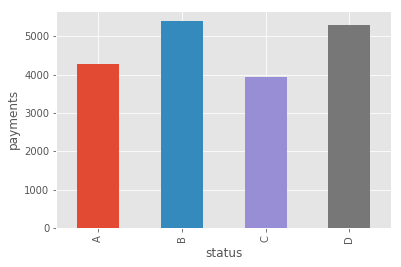

In [149]:
a = loan.groupby(
    by="status", axis=0, level=None, as_index=True, sort=True, group_keys=True
)
a.payments.mean().plot(kind="bar")
plt.ylabel("payments")


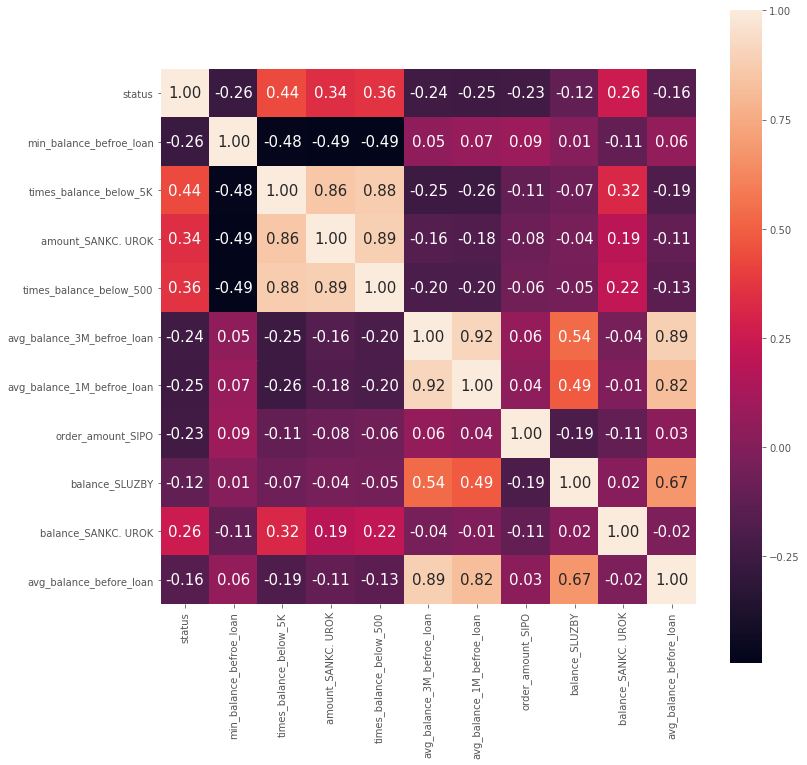

In [150]:
# plot heatmap
import seaborn as sns

cols = list(importance.feature[:10])
cols.insert(0, "status")
corrcoef_map = np.corrcoef(df[cols].values.T)
fig, ax = plt.subplots(figsize=(12, 12))  # Sample figsize in inches
hm = sns.heatmap(
    corrcoef_map,
    cbar=True,
    annot=True,
    square=True,
    fmt=".2f",
    annot_kws={"size": 15},
    yticklabels=cols,
    xticklabels=cols,
    ax=ax,
)


# Create X, y, training/testing set split

In [151]:
X = df.loc[:, df.columns != "status"]
y = df.loc[:, "status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


# Modeling: Random Forest

In [152]:
rf = ensemble.RandomForestClassifier(
    n_estimators=800,
    criterion="gini",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features="auto",
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=1,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


In [153]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       192
           1       0.88      0.54      0.67        13

   micro avg       0.97      0.97      0.97       205
   macro avg       0.92      0.77      0.82       205
weighted avg       0.96      0.97      0.96       205



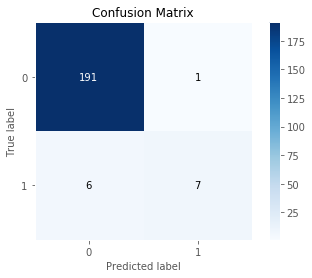

In [154]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)


In [155]:
fi = rf.feature_importances_


In [156]:
feature_cols = X_test.columns
importance = pd.DataFrame(
    {"feature": feature_cols, "importance": rf.feature_importances_}
)


Text(0,0.5,'importance')

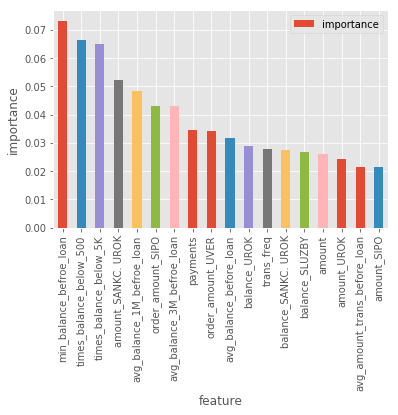

In [157]:
feature_cols = X_test.columns
importance = pd.DataFrame(
    {"feature": feature_cols[:], "importance": rf.feature_importances_[:]}
)
importance.sort_values(
    by="importance",
    axis=0,
    ascending=False,
    inplace=True,
    kind="quicksort",
    na_position="last",
)
importance[:18].plot(x="feature", y="importance", kind="bar")
plt.ylabel("importance")


# Decision Tree

In [158]:
clf = tree.DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    class_weight=None,
    presort=False,
)

model = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [159]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       192
           1       0.91      0.77      0.83        13

   micro avg       0.98      0.98      0.98       205
   macro avg       0.95      0.88      0.91       205
weighted avg       0.98      0.98      0.98       205



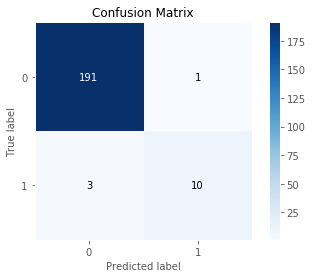

In [160]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)


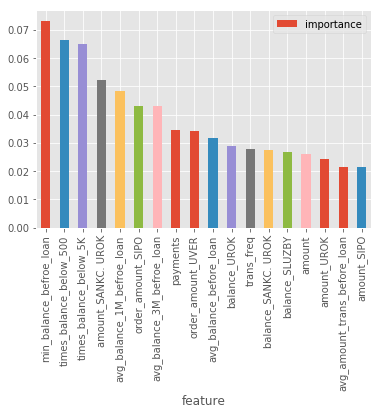

In [161]:
feature_cols = X_test.columns
importance = pd.DataFrame(
    {"feature": feature_cols[:], "importance": rf.feature_importances_[:]}
)
importance.sort_values(
    by="importance",
    axis=0,
    ascending=False,
    inplace=True,
    kind="quicksort",
    na_position="last",
)
importance[:18].plot(x="feature", y="importance", kind="bar")


# Gradient Boosting Classifier

In [162]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(
    loss="deviance",
    learning_rate=0.1,
    n_estimators=200,
    subsample=1.0,
    criterion="friedman_mse",
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=3,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    init=None,
    random_state=None,
    max_features=None,
)
model = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [163]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       192
           1       0.90      0.69      0.78        13

   micro avg       0.98      0.98      0.98       205
   macro avg       0.94      0.84      0.88       205
weighted avg       0.97      0.98      0.97       205



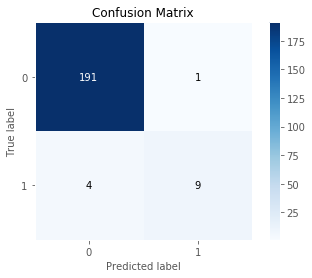

In [164]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)


# Feature Scaling - for SVM & Logistic Regression

In [165]:
# Standard processing
sc = StandardScaler()
X.drop(['age_bin'], axis=1, inplace=True)
X = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)



/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


# SVM

In [166]:
svc = svm.SVC(
    C=5,
    kernel="rbf",
    degree=3,
    gamma="auto",
    coef0=0.0,
    shrinking=True,
    probability=False,
    tol=0.001,
    cache_size=200,
    class_weight=None,
    verbose=False,
    max_iter=-1,
    decision_function_shape="ovr",
    random_state=None,
)
model = svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)


In [167]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.99      0.95       179
           1       0.83      0.38      0.53        26

   micro avg       0.91      0.91      0.91       205
   macro avg       0.88      0.69      0.74       205
weighted avg       0.91      0.91      0.90       205



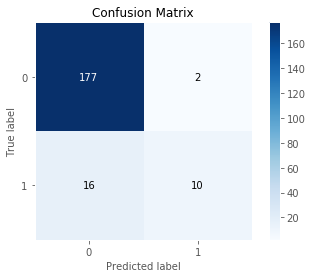

In [168]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)


# Logistic Regression

In [169]:
lr = LogisticRegression(penalty="l1", C=1).fit(X_train, y_train)
y_pred = lr.predict(X_test)


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [170]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.99      0.95       179
           1       0.85      0.42      0.56        26

   micro avg       0.92      0.92      0.92       205
   macro avg       0.88      0.71      0.76       205
weighted avg       0.91      0.92      0.90       205



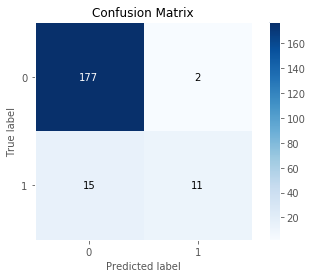

In [171]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)


# Try: Use only two features **to plot Decision Boundary

In [172]:
def plot_decision_boundary(model, X, y):
    X_max = X.max(axis=0)
    X_min = X.min(axis=0)
    xticks = np.linspace(X_min[0], X_max[0], 100)
    yticks = np.linspace(X_min[1], X_max[1], 100)
    xx, yy = np.meshgrid(xticks, yticks)
    ZZ = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = ZZ >= 0.5
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots()
    ax = plt.gca()
    ax.contourf(xx, yy, Z, cmap=plt.cm.PRGn, alpha=0.6)
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, alpha=0.6)


In [173]:
X = df[["min_balance_befroe_loan", "times_balance_below_5K"]]
y = df["status"]


In [174]:
rf = ensemble.RandomForestClassifier(
    n_estimators=500,
    criterion="gini",
    max_depth=4,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features="auto",
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=1,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
)

X_train, X_test, y_train, y_test = train_test_split(X, y)
model = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1 = f1_score(y_pred, y_test)
f1


0.375

In [175]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      1.00      0.97       158
           1       1.00      0.23      0.38        13

   micro avg       0.94      0.94      0.94       171
   macro avg       0.97      0.62      0.67       171
weighted avg       0.95      0.94      0.92       171



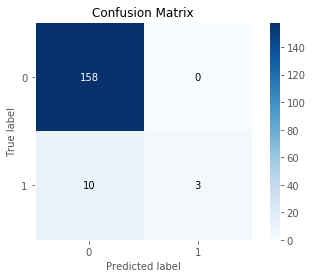

In [176]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)


Text(0,0.5,'times_balance_below_5K')

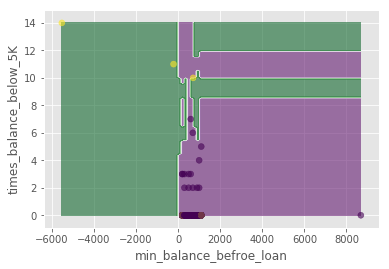

In [177]:
plot_decision_boundary(model, X_test, y_test)
plt.xlabel("min_balance_befroe_loan")
plt.ylabel("times_balance_below_5K")


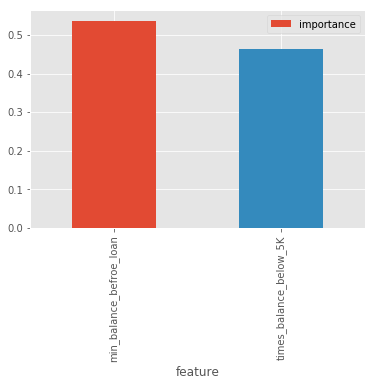

In [178]:
feature_cols = X_test.columns
importance = pd.DataFrame(
    {"feature": feature_cols[:], "importance": rf.feature_importances_[:]}
)
importance.sort_values(
    by="importance",
    axis=0,
    ascending=False,
    inplace=True,
    kind="quicksort",
    na_position="last",
)
importance[:18].plot(x="feature", y="importance", kind="bar")


# Conclusion
In the bank loan default prediction, my assumption is banks want to control the loss to a acceptable level, without missing some good client. This means balance the customers be grouped as potential good/bad customers, and their profiles will be checked carefully. 
Banks can detect the default behaviours in the earlier stage and conduct the corresponding actions to reduce the possible loss. That's why all of the new features I created are only based on the dates of the transfer must before the date that client apply for a loan.